In [1]:
####Импорт стандартных библиотек для работы в ноутбуке####
import random
import time
import re
from tqdm.notebook import tqdm
import itertools
#####Библиотеки для парсинга сайтов####
import requests
from bs4 import BeautifulSoup
#from fake_useragent import UserAgent - Используем для генерации разного useragent при парсинге сайта
####Библиотеки для обработки данных и визуализации####
import pandas as pd
import matplotlib.pyplot as plt
####Библиотеки для работы с графами####
import networkx as nx
import community
####Библиотека для кластеризации####
from sklearn.cluster import KMeans

### Функция парсер для сайта restoclub
**Данная функция получает на вход главную ссылку на сайт с ресторанами или кафе Москвы, далее генерирует случаный user-agent для избежания блокировок со стороны сайта от ботов. После чего функция проходит по каждой странице сайта и получает html разметку для каждой карточки заведения. Из карточки заведения получаем следующие поля:**
- Название заведения
- id заведения на сайте
- Описание заведения
- Типы кухни, представленные в заведении
- Количество отзывов
- Рейтинг заведения(проставлен не везде)
- Средний чек без напитков

In [ ]:
def parser_rest(main_url, num_pages):
    result = []
    for page in tqdm(range(2, num_pages)):
        headers={'User-Agent': UserAgent().chrome}
        url = f'{main_url}/{page}'
        response = requests.get(url, headers = headers)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            res = soup.find('ul', class_='page-search__list')

            if page > 5:
                restaraunts = res.find_all('li', class_ = 'page-search__item')

                print(f'Количество ресторанов: {len(restaraunts)}, страница {page}')
                for rest in restaraunts:

                    restaurant_info = {}
                    descr = rest.find('div', class_ = 'search-place-card__description')
                    place_id = rest.find('div', class_='search-place-card')
                    name = rest.find('div', class_='search-place-card')
                    link = rest.find('a', class_= 'search-place-title__link')
                    if link:
                        link = link['href']

                        rest_url = f'https://www.restoclub.ru{link}'

                        response_page = requests.get(rest_url, headers = headers)

                        if response_page.status_code == 200:
                            soup2 = BeautifulSoup(response_page.text, 'html.parser')
                            place = soup2.find('span', class_='Subway_SubwayName__dLFOK')
                            restaurant_info['place'] = place.text if place else ''
                        else:
                            print("Ошибка при запросе:", response_page.status_code)

                    restaurant_info['place_id'] = int(place_id['data-id']) if place_id else ''
                    restaurant_info['name'] = name['data-name'] if name else ''

                    if descr:
                        description = descr.find('div', class_= 'search-place-card__about')
                        cuisines_element = descr.find('li', class_='search-place-card__info-item _cuisine')

                        if descr.find('div', class_='rating__value very-high'):
                            rating = descr.find('div', class_='rating__value very-high')
                            restaurant_info['rating'] = rating.text if rating else ''
                        elif descr.find('div', class_='rating__value low'):
                            rating = descr.find('div', class_='rating__value low')
                            restaurant_info['rating'] = rating.text if rating else ''
                        elif descr.find('div', class_='rating__value medium'):
                            rating = descr.find('div', class_='rating__value medium')
                            restaurant_info['rating'] = rating.text if rating else ''
                        elif descr.find('div', class_='rating__value high'):
                            rating = descr.find('div', class_='rating__value high')
                            restaurant_info['rating'] = rating.text if rating else ''

                        cnt_reviews = descr.find('a', class_='search-place-rating__reviews')
                        bill = descr.find('li', class_='search-place-card__info-item _bill')

                        restaurant_info['description'] = description.text if description else ''
                        restaurant_info['cuisines'] = [cuisine.text for cuisine in cuisines_element.find_all('span', class_='cuisine')] if cuisines_element else []
                        restaurant_info['cnt_reviews'] = cnt_reviews.text if cnt_reviews else ''
                        restaurant_info['bill'] = bill['title'] if bill else ''

                        result.append(restaurant_info)
                    else:
                        result.append(restaurant_info)
            else:
                restaraunts = res.find_all('li', class_ = 'page-search__item _premium')

                print(f'Количество ресторанов: {len(restaraunts)}, страница {page}')
                for rest in restaraunts:

                    restaurant_info = {}
                    descr = rest.find('div', class_ = 'search-place-card__description')
                    place_id = rest.find('div', class_='search-place-card')
                    name = rest.find('div', class_='search-place-card')
                    link = rest.find('a', class_= 'search-place-title__link')
                    if link:
                        link = link['href']
                        rest_url = f'https://www.restoclub.ru{link}'

                        response_page = requests.get(rest_url, headers = headers)

                        if response_page.status_code == 200:
                            soup2 = BeautifulSoup(response_page.text, 'html.parser')
                            place = soup2.find('span', class_='Subway_SubwayName__dLFOK')
                            restaurant_info['place'] = place.text if place else ''
                        else:
                            print("Ошибка при запросе:", response_page.status_code)


                    restaurant_info['place_id'] = int(place_id['data-id']) if place_id else ''
                    restaurant_info['name'] = name['data-name'] if name else ''

                    if descr:

                        description = descr.find('div', class_= 'search-place-card__about')
                        cuisines_element = descr.find('li', class_='search-place-card__info-item _cuisine')

                        if descr.find('div', class_='rating__value very-high'):
                            rating = descr.find('div', class_='rating__value very-high')
                            restaurant_info['rating'] = rating.text if rating else ''

                        elif descr.find('div', class_='rating__value low'):
                            rating = descr.find('div', class_='rating__value low')
                            restaurant_info['rating'] = rating.text if rating else ''

                        elif descr.find('div', class_='rating__value medium'):
                            rating = descr.find('div', class_='rating__value medium')
                            restaurant_info['rating'] = rating.text if rating else ''

                        elif descr.find('div', class_='rating__value high'):
                            rating = descr.find('div', class_='rating__value high')
                            restaurant_info['rating'] = rating.text if rating else ''

                        cnt_reviews = descr.find('a', class_='search-place-rating__reviews')
                        bill = descr.find('li', class_='search-place-card__info-item _bill')

                        restaurant_info['description'] = description.text if description else ''
                        restaurant_info['cuisines'] = [cuisine.text for cuisine in cuisines_element.find_all('span', class_='cuisine')] if cuisines_element else []
                        restaurant_info['cnt_reviews'] = cnt_reviews.text if cnt_reviews else ''
                        restaurant_info['bill'] = bill['title'] if bill else ''
                        result.append(restaurant_info)
                    else:
                        result.append(restaurant_info)
        else:
            print("Ошибка при запросе:", response.status_code)
        sleep_time = random.uniform(2, 5)
        time.sleep(sleep_time)
    return result

In [ ]:
def extract_number(text):
    match = re.search(r'\d+', text)
    if match:
        return int(match.group())
    else:
        return None

**Парсим кафе и рестораны Москвы**

In [ ]:
cafes_dict = parser_rest('https://www.restoclub.ru/msk/search/kafe-moskvy', num_pages=32)
rests_dict = parser_rest('https://www.restoclub.ru/msk/search/restorany-moskvy', num_pages=50)

  0%|          | 0/30 [00:00<?, ?it/s]

Количество ресторанов: 51, страница 2
Количество ресторанов: 51, страница 3
Количество ресторанов: 51, страница 4
Количество ресторанов: 51, страница 5
Количество ресторанов: 51, страница 6
Количество ресторанов: 51, страница 7
Количество ресторанов: 51, страница 8
Количество ресторанов: 51, страница 9
Количество ресторанов: 51, страница 10
Количество ресторанов: 51, страница 11
Количество ресторанов: 51, страница 12
Количество ресторанов: 51, страница 13
Количество ресторанов: 51, страница 14
Количество ресторанов: 51, страница 15
Количество ресторанов: 51, страница 16
Количество ресторанов: 51, страница 17
Количество ресторанов: 51, страница 18
Ошибка при запросе: 403
Ошибка при запросе: 403
Ошибка при запросе: 403
Ошибка при запросе: 403
Ошибка при запросе: 403
Ошибка при запросе: 403
Ошибка при запросе: 403
Количество ресторанов: 51, страница 19
Ошибка при запросе: 403
Ошибка при запросе: 403
Ошибка при запросе: 403
Ошибка при запросе: 403
Ошибка при запросе: 403
Ошибка при запросе

### Обрабатываем датафрейм после парсинга
- Преобразуем типы данных
- Выделяем нужные числовые признаки из столбцов

In [ ]:
cafes = pd.DataFrame(cafes_dict)
restaraunts = pd.DataFrame(rests_dict)

In [ ]:
cafes = cafes[cafes['place']!='']
restaraunts = restaraunts[restaraunts['place']!='']

In [ ]:
cafes.dropna(subset=['bill'], inplace=True)
restaraunts.dropna(subset=['place'], inplace=True)

In [ ]:
cafes['average_check'] = cafes['bill'].apply(extract_number)
cafes['reviews'] = cafes['cnt_reviews'].apply(extract_number)
cafes.drop('bill', axis=1, inplace=True)
cafes.drop('cnt_reviews', axis=1, inplace=True)

restaraunts['average_check'] = restaraunts['bill'].apply(extract_number)
restaraunts['reviews'] = restaraunts['cnt_reviews'].apply(extract_number)
restaraunts.drop('bill', axis=1, inplace=True)
restaraunts.drop('cnt_reviews', axis=1, inplace=True)

In [ ]:
cafes['place_id'] = cafes['place_id'].astype(int)
cafes['rating'] = cafes['rating'].astype(float)
restaraunts['place_id'] = restaraunts['place_id'].astype(int)
restaraunts['rating'] = restaraunts['rating'].astype(float)

In [ ]:
cafes.to_csv('cafes.csv', index=False)
restaraunts.to_csv('restaurants.csv', index=False)

### Объединяем два датафрейма в один и удаляем дубликаты

In [ ]:
frames = [cafes, restaraunts]
places = pd.concat(frames)

In [ ]:
places = places.drop_duplicates(subset=['place_id'])

In [ ]:
places.to_csv('places.csv', index=False)

### Построение графа на основе датафрейма

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
places = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TSS/places (1) (1).csv')

In [4]:
places = places[places['cuisines']!='[]']
places.dropna(subset=['place'], inplace=True)
places = places.reset_index(drop=True)

#### Создание графов

In [5]:
place1 = nx.Graph()

for index, row in places.iterrows():
    idx = index
    place_id = row['place_id']
    place = row['place']
    name = row['name']
    description = row['description']
    cuisines = eval(row['cuisines'])
    rating = row['rating']
    cnt_reviews = row['reviews']
    bill = row['average_check']

    place1.add_node(idx,
               #place_id=place_id,
               place=place,
               name=name,
               #description=description,
               cuisines=cuisines,
               rating=rating,
               cnt_reviews=cnt_reviews,
               bill=bill)

for (node1, data1), (node2, data2) in itertools.combinations(place1.nodes(data=True), 2):

    if any(cuisine in data2['cuisines'] for cuisine in data1['cuisines']):
        place1.add_edge(node1, node2, relation='similar_cuisine')
        weight = (data1['bill'] + data2['bill']) / 2
        if weight > 0:  # Убедимся, что вес положительный
            place1.add_edge(node1, node2, relation='similar_cuisine', weight=weight)

In [6]:
place2 = nx.Graph()

for index, row in places.iterrows():
    idx = index
    place_id = row['place_id']
    place = row['place']
    name = row['name']
    description = row['description']
    cuisines = eval(row['cuisines'])
    rating = row['rating']
    cnt_reviews = row['reviews']
    bill = row['average_check']

    place2.add_node(idx,
               #place_id=place_id,
               place=place,
               name=name,
               #description=description,
               cuisines=cuisines,
               rating=rating,
               cnt_reviews=cnt_reviews,
               bill=bill)


for (node1, data1), (node2, data2) in itertools.combinations(place2.nodes(data=True), 2):
    common_cuisines = set(data1['cuisines']).intersection(data2['cuisines'])
    weight = len(common_cuisines) / min(len(data1['cuisines']), len(data2['cuisines']))

    if common_cuisines:
        place2.add_edge(node1, node2, relation='similar_cuisine', weight=weight)

**Статистики по графaм**

In [7]:
num_edges_1 = place1.number_of_edges()
num_nodes_1 = place1.number_of_nodes()
density_1 = nx.density(place1)
average_degree_1 = sum(dict(place1.degree()).values()) / num_nodes_1
print("Количество связей (рёбер) в графе 1:", num_edges_1)
print("Количество узлов (вершин) в графе 1:", num_nodes_1)
print(f"Средняя плотность в графе 1: {density_1}")
print(f"Средняя степень узлов: {average_degree_1}")

Количество связей (рёбер) в графе 1: 1610173
Количество узлов (вершин) в графе 1: 2818
Средняя плотность в графе 1: 0.4056716886449074
Средняя степень узлов: 1142.777146912704


In [8]:
num_edges_2 = place2.number_of_edges()
num_nodes_2 = place2.number_of_nodes()
density_2 = nx.density(place2)
average_degree_2 = sum(dict(place2.degree()).values()) / num_nodes_2
print("Количество связей (рёбер) в графе 1:", num_edges_2)
print("Количество узлов (вершин) в графе 1:", num_nodes_2)
print(f"Средняя плотность в графе 1: {density_2}")
print(f"Средняя степень узлов: {average_degree_2}")

Количество связей (рёбер) в графе 1: 1610173
Количество узлов (вершин) в графе 1: 2818
Средняя плотность в графе 1: 0.4056716886449074
Средняя степень узлов: 1142.777146912704


In [9]:
random_nodes_1 = random.sample(place1.nodes(), min(30, len(place1.nodes())))
subgraph_1 = place1.subgraph(random_nodes_1)

<ipython-input-9-363ad12e3fd4>:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_nodes_1 = random.sample(place1.nodes(), min(30, len(place1.nodes())))


In [10]:
random_nodes_2 = random.sample(place2.nodes(), min(30, len(place2.nodes())))
subgraph_2 = place2.subgraph(random_nodes_2)

<ipython-input-10-eec93a93b47f>:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_nodes_2 = random.sample(place2.nodes(), min(30, len(place2.nodes())))


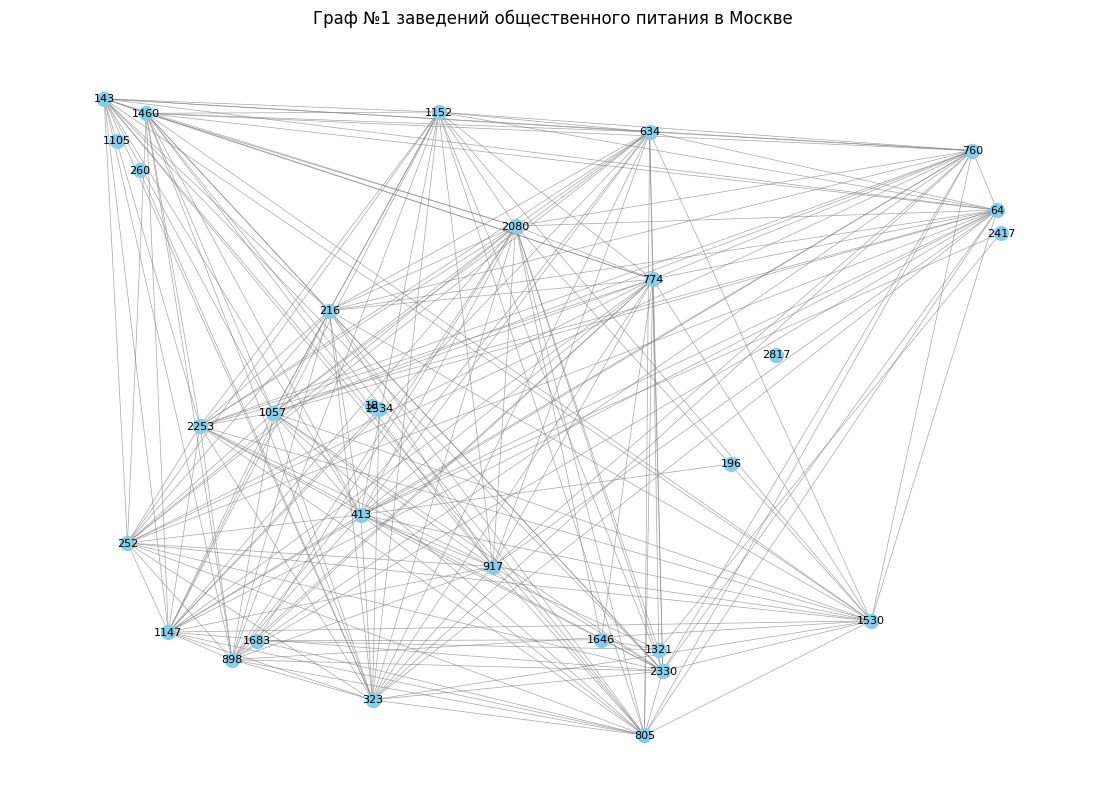

In [11]:
plt.figure(figsize=(14, 10))

pos = nx.random_layout(subgraph_1, seed=42)

nx.draw_networkx_nodes(subgraph_1, pos, node_size=100, node_color='skyblue')

nx.draw_networkx_labels(subgraph_1, pos, font_size=8)

nx.draw_networkx_edges(subgraph_1, pos, width=0.5, alpha=0.7, edge_color='gray')

plt.title('Граф №1 заведений общественного питания в Москве')

plt.axis('off')
plt.show()

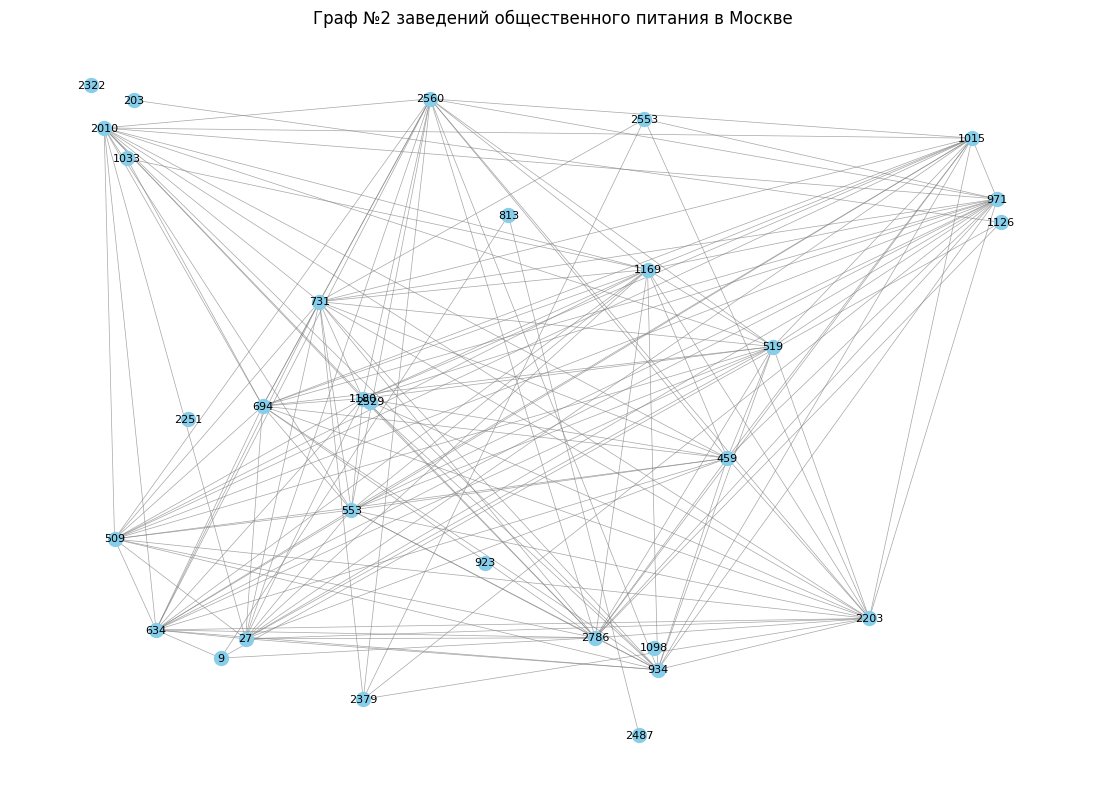

In [12]:
plt.figure(figsize=(14, 10))

pos = nx.random_layout(subgraph_2, seed=42)

nx.draw_networkx_nodes(subgraph_2, pos, node_size=100, node_color='skyblue')

nx.draw_networkx_labels(subgraph_2, pos, font_size=8)

nx.draw_networkx_edges(subgraph_2, pos, width=0.5, alpha=0.7, edge_color='gray')

plt.title('Граф №2 заведений общественного питания в Москве')

plt.axis('off')
plt.show()

**Мера центральности узлов в графе**
- Мера центральности узлов в графе - это числовая оценка, которая показывает, насколько важен или центральный каждый узел в графе. Она позволяет определить, какие узлы являются ключевыми или влиятельными в структуре графа.

- Мера центральности по степени

In [13]:
degree_centrality_1 = nx.degree_centrality(place1)
sorted_centrality_1 = sorted(degree_centrality_1.items(), key=lambda x: x[1], reverse=True)
df_degree_centrality_1 = places.iloc[[tup[0] for tup in sorted_centrality_1[:20]]]

degree_centrality_2 = nx.degree_centrality(place2)
sorted_centrality_2 = sorted(degree_centrality_2.items(), key=lambda x: x[1], reverse=True)
df_degree_centrality_2 = places.iloc[[tup[0] for tup in sorted_centrality_2[:20]]]

In [14]:
df_degree_centrality_1

,place,place_id,name,description,cuisines,rating,average_check,reviews
1466,Беговая,49150,Lariote,Двухуровневый ресторан смешанной кухни в 1-ом ...,"['европейская', 'итальянская', 'грузинская']",9.8,1800.0,4.0
2309,Ботанический сад,49432,Джорджио и Джорджия,Итальяно-грузинский ресторан на первом этаже а...,"['европейская', 'итальянская', 'кавказская']",NaN,1400.0,NaN
2682,Академическая,48917,Сцена,Ресторан с караоке на Новочеремушкинской улице,"['европейская', 'кавказская', 'итальянская']",NaN,1200.0,NaN
2187,Краснопресненская,42689,Белый дом,Элегантный ресторан и караоке-бар в Глубоком п...,"['смешанная', 'грузинская', 'европейская']",NaN,2000.0,NaN
2736,Мякинино,33077,Фьюжн,Ресторан и банкетный зал на втором этаже ТЦ «К...,"['смешанная', 'грузинская', 'европейская']",NaN,2000.0,NaN
1113,Шоссе Энтузиастов,41008,Южный дворик,Кафе кавказской кухни в Балашихе,"['кавказская', 'смешанная', 'европейская']",NaN,1200.0,NaN
1363,Сокольники,32604,Элит,Европейский ресторан в районе парка Сокольники,"['европейская', 'кавказская', 'смешанная']",10.0,1500.0,2.0
2614,Окружная,48560,Сады Семирамиды,Большой двухэтажный ресторан на Дмитровском шоссе,"['кавказская', 'европейская', 'смешанная']",NaN,1600.0,NaN
1961,Бабушкинская,33809,Акбаш,Ресторан кавказской кухни в Медведково,"['европейская', 'русская', 'грузинская']",NaN,1500.0,NaN
1990,Выхино,44033,White Hall,Панорамный европейский ресторан в Выхино,"['европейская', 'русская', 'кавказская']",NaN,1500.0,NaN


In [15]:
df_degree_centrality_2

,place,place_id,name,description,cuisines,rating,average_check,reviews
1466,Беговая,49150,Lariote,Двухуровневый ресторан смешанной кухни в 1-ом ...,"['европейская', 'итальянская', 'грузинская']",9.8,1800.0,4.0
2309,Ботанический сад,49432,Джорджио и Джорджия,Итальяно-грузинский ресторан на первом этаже а...,"['европейская', 'итальянская', 'кавказская']",NaN,1400.0,NaN
2682,Академическая,48917,Сцена,Ресторан с караоке на Новочеремушкинской улице,"['европейская', 'кавказская', 'итальянская']",NaN,1200.0,NaN
2187,Краснопресненская,42689,Белый дом,Элегантный ресторан и караоке-бар в Глубоком п...,"['смешанная', 'грузинская', 'европейская']",NaN,2000.0,NaN
2736,Мякинино,33077,Фьюжн,Ресторан и банкетный зал на втором этаже ТЦ «К...,"['смешанная', 'грузинская', 'европейская']",NaN,2000.0,NaN
1113,Шоссе Энтузиастов,41008,Южный дворик,Кафе кавказской кухни в Балашихе,"['кавказская', 'смешанная', 'европейская']",NaN,1200.0,NaN
1363,Сокольники,32604,Элит,Европейский ресторан в районе парка Сокольники,"['европейская', 'кавказская', 'смешанная']",10.0,1500.0,2.0
2614,Окружная,48560,Сады Семирамиды,Большой двухэтажный ресторан на Дмитровском шоссе,"['кавказская', 'европейская', 'смешанная']",NaN,1600.0,NaN
1961,Бабушкинская,33809,Акбаш,Ресторан кавказской кухни в Медведково,"['европейская', 'русская', 'грузинская']",NaN,1500.0,NaN
1990,Выхино,44033,White Hall,Панорамный европейский ресторан в Выхино,"['европейская', 'русская', 'кавказская']",NaN,1500.0,NaN


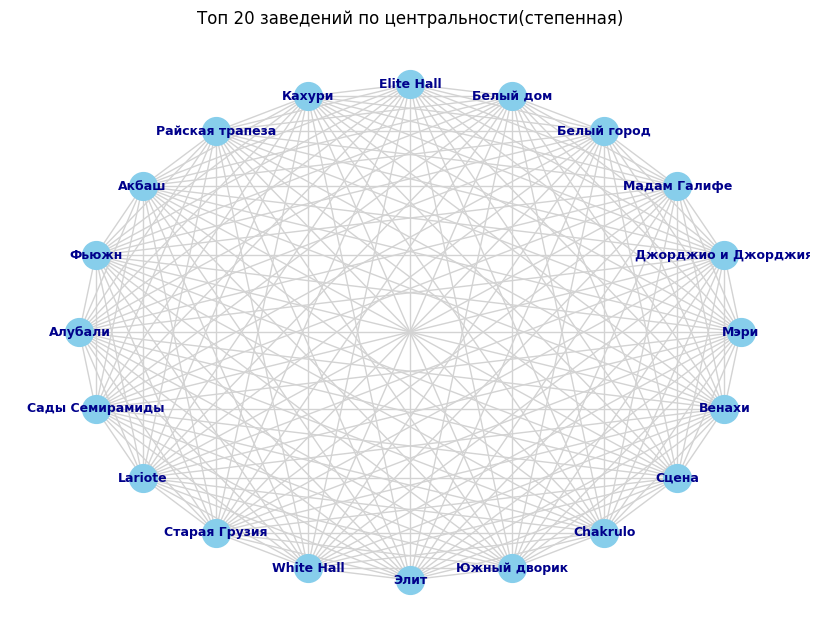

In [16]:
node_ids = df_degree_centrality_1.index.tolist()

subgraph = place1.subgraph(node_ids)

edge_color = 'lightgrey'
font_color = 'darkblue'
pos = nx.circular_layout(subgraph)

plt.figure(figsize=(8, 6))
nx.draw(subgraph,
        pos=pos,
        with_labels=True,
        labels=nx.get_node_attributes(subgraph, 'name'),
        node_size=400,
        node_color='skyblue',
        font_size=9,
        font_weight='bold',
        edge_color=edge_color,
        font_color=font_color)
plt.title("Топ 20 заведений по центральности(степенная)")
plt.show()

- Мера центральности по собственному вектору

In [17]:
eigenvector_centrality_1 = nx.eigenvector_centrality(place1, weight='weight')
sorted_eigenvector_centrality_1 = sorted(eigenvector_centrality_1.items(), key=lambda x: x[1], reverse=True)
df_eigenvector_centrality_1 = places.iloc[[tup[0] for tup in sorted_eigenvector_centrality_1[:20]]]

eigenvector_centrality_2 = nx.eigenvector_centrality(place2, weight='weight')
sorted_eigenvector_centrality_2 = sorted(eigenvector_centrality_2.items(), key=lambda x: x[1], reverse=True)
df_eigenvector_centrality_2 = places.iloc[[tup[0] for tup in sorted_eigenvector_centrality_2[:20]]]

In [18]:
df_eigenvector_centrality_1

,place,place_id,name,description,cuisines,rating,average_check,reviews
2515,Киевская,58513,Oltremare,Ресторан традиционной итальянской кухни от Luc...,"['европейская', 'итальянская']",NaN,7600.0,NaN
1266,Третьяковская,43127,Drinks @ Dinners,Двухэтажный ресторан авторской кухни на Пятниц...,"['европейская', 'русская']",9.2,7000.0,16.0
2082,Александровский сад,47272,Romanov Cigar Lounge,Элегантный ресторан и сигарный клуб в комплекс...,"['европейская', 'пицца', 'стейки']",NaN,6100.0,NaN
1208,Киевская,31181,Buono,Панорамный итальянский ресторан от Ginza Project,"['европейская', 'итальянская', 'рыба и морепро...",9.5,6000.0,15.0
1871,Деловой центр,49257,Azur by Erdal,Мясной панорамный ресторан премиум-класса на 1...,"['европейская', 'средиземноморская']",NaN,6000.0,NaN
2215,Выставочная,60292,Buffalero Di Mare,Премиальный стейк-хаус в Сити,"['европейская', 'стейки']",NaN,5600.0,NaN
1148,Киевская,31242,Теплоход VIP Ривер Палас,Роскошный панорамный теплоход для проведения я...,"['европейская', 'суши', 'смешанная']",9.1,5500.0,13.0
1890,Лубянка,54564,Rodina,"Ресторан с танцевальной площадкой, расположивш...","['европейская', 'азиатская', 'русская']",10.0,5500.0,2.0
2549,Парк культуры,44907,Piazza Italiana,Премиум-ресторан европейской кухни на Пречисте...,"['европейская', 'итальянская']",NaN,5000.0,NaN
1272,Улица 1905 года,35539,Sabor De La Vida,Элегантный ресторан и винный магазин на улице ...,"['европейская', 'рыба и морепродукты']",9.9,5000.0,35.0


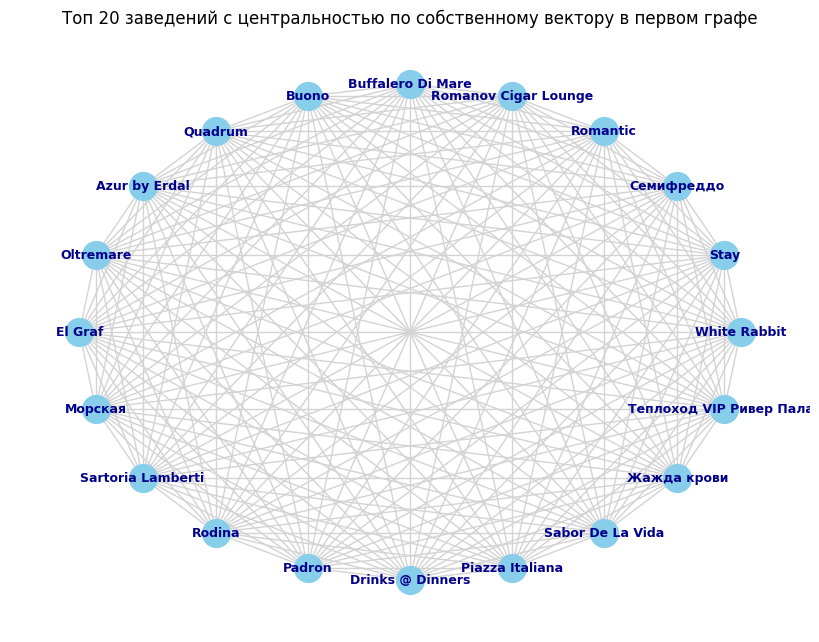

In [19]:
node_ids = df_eigenvector_centrality_1.index.tolist()

subgraph = place1.subgraph(node_ids)

edge_color = 'lightgrey'
font_color = 'darkblue'
pos = nx.circular_layout(subgraph)

plt.figure(figsize=(8, 6))
nx.draw(subgraph,
        pos=pos,
        with_labels=True,
        labels=nx.get_node_attributes(subgraph, 'name'),
        node_size=400,
        node_color='skyblue',
        font_size=9,
        font_weight='bold',
        edge_color=edge_color,
        font_color=font_color)
plt.title("Топ 20 заведений с центральностью по собственному вектору в первом графе")
plt.show()

In [20]:
df_eigenvector_centrality_2

,place,place_id,name,description,cuisines,rating,average_check,reviews
6,Тверская,46719,Скворец,Симпатичное дог-френдли кафе с поздними завтра...,['европейская'],8.5,1300.0,22.0
10,Курская,38959,OMG! Coffee,Уютное кафе на Нижнем Сусальном переулке,['европейская'],NaN,1000.0,NaN
22,Крестьянская Застава,50602,Cava / ex. Ким Хаус,Караоке-бар на Марксистской,['европейская'],10.0,1500.0,11.0
27,Таганская,57899,Черёмуха,Уютная кофейня с завтраками,['европейская'],10.0,400.0,3.0
29,Академическая,46973,Фантазеры,Кафе с завтраками целый день на Ленинском прос...,['европейская'],7.7,1600.0,27.0
54,Молодежная,40352,Лампа,"Уютное кафе с европейской, итальянской и русск...",['европейская'],9.7,1200.0,2.0
55,Бауманская,40727,Поварская лавка,кафе,['европейская'],10.0,800.0,22.0
63,Царицыно,40993,Андерсон,Сетевое семейное кафе в парке Царицыно,['европейская'],9.4,1500.0,6.0
64,Новокузнецкая,46475,Daily Green,Душевная кофейня с завтраками весь день,['европейская'],10.0,1200.0,7.0
74,Бабушкинская,42628,Hi пятница,кафе,['европейская'],10.0,NaN,7.0


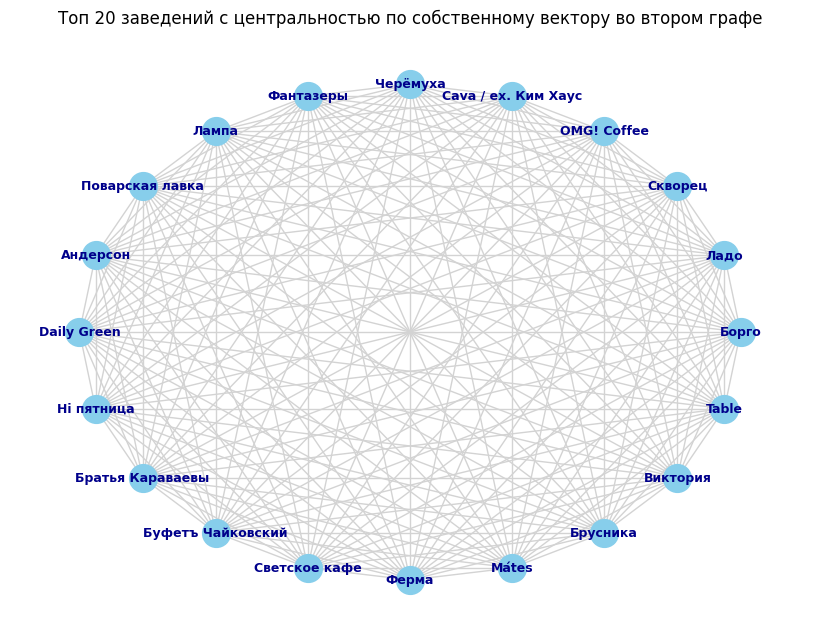

In [21]:
node_ids = df_eigenvector_centrality_2.index.tolist()

subgraph = place2.subgraph(node_ids)

edge_color = 'lightgrey'
font_color = 'darkblue'
pos = nx.circular_layout(subgraph)

plt.figure(figsize=(8, 6))
nx.draw(subgraph,
        pos=pos,
        with_labels=True,
        labels=nx.get_node_attributes(subgraph, 'name'),
        node_size=400,
        node_color='skyblue',
        font_size=9,
        font_weight='bold',
        edge_color=edge_color,
        font_color=font_color)
plt.title("Топ 20 заведений с центральностью по собственному вектору во втором графе")
plt.show()

- PageRank

In [22]:
pagerank_1 = nx.pagerank(place1, weight='weight')
sorted_pagerank_1 = sorted(pagerank_1.items(), key=lambda x: x[1], reverse=True)
df_pagerank_1 = places.iloc[[tup[0] for tup in sorted_pagerank_1[:20]]]

pagerank_2 = nx.pagerank(place2, weight='weight')
sorted_pagerank_2 = sorted(pagerank_2.items(), key=lambda x: x[1], reverse=True)
df_pagerank_2 = places.iloc[[tup[0] for tup in sorted_pagerank_2[:20]]]

In [23]:
df_pagerank_1

,place,place_id,name,description,cuisines,rating,average_check,reviews
2515,Киевская,58513,Oltremare,Ресторан традиционной итальянской кухни от Luc...,"['европейская', 'итальянская']",NaN,7600.0,NaN
1890,Лубянка,54564,Rodina,"Ресторан с танцевальной площадкой, расположивш...","['европейская', 'азиатская', 'русская']",10.0,5500.0,2.0
1266,Третьяковская,43127,Drinks @ Dinners,Двухэтажный ресторан авторской кухни на Пятниц...,"['европейская', 'русская']",9.2,7000.0,16.0
1208,Киевская,31181,Buono,Панорамный итальянский ресторан от Ginza Project,"['европейская', 'итальянская', 'рыба и морепро...",9.5,6000.0,15.0
1148,Киевская,31242,Теплоход VIP Ривер Палас,Роскошный панорамный теплоход для проведения я...,"['европейская', 'суши', 'смешанная']",9.1,5500.0,13.0
2082,Александровский сад,47272,Romanov Cigar Lounge,Элегантный ресторан и сигарный клуб в комплекс...,"['европейская', 'пицца', 'стейки']",NaN,6100.0,NaN
1871,Деловой центр,49257,Azur by Erdal,Мясной панорамный ресторан премиум-класса на 1...,"['европейская', 'средиземноморская']",NaN,6000.0,NaN
1126,Арбатская,58641,AYU,Японский ресторан омакасе проекта WA Garden в ...,"['японская', 'рыба и морепродукты']",10.0,25000.0,3.0
2215,Выставочная,60292,Buffalero Di Mare,Премиальный стейк-хаус в Сити,"['европейская', 'стейки']",NaN,5600.0,NaN
2549,Парк культуры,44907,Piazza Italiana,Премиум-ресторан европейской кухни на Пречисте...,"['европейская', 'итальянская']",NaN,5000.0,NaN


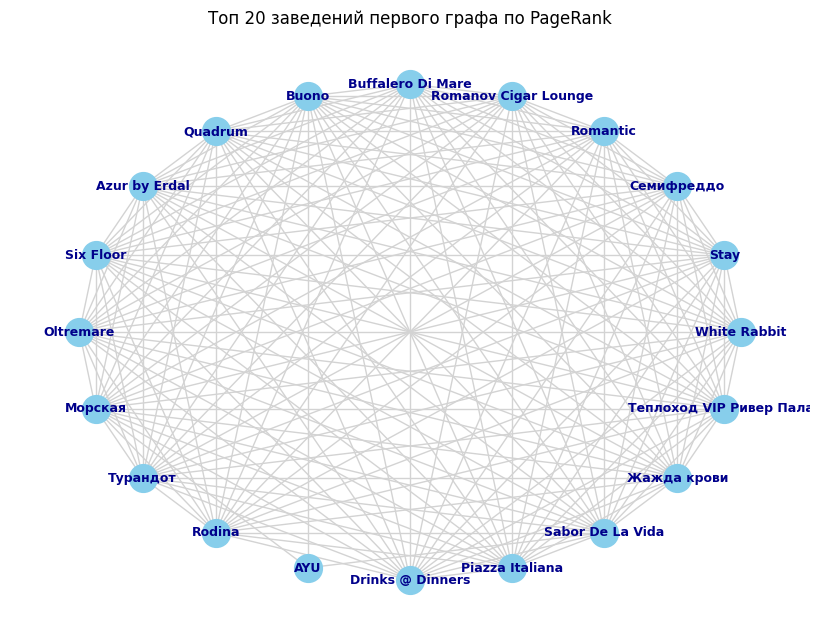

In [24]:
node_ids = df_pagerank_1.index.tolist()

subgraph = place1.subgraph(node_ids)

edge_color = 'lightgrey'
font_color = 'darkblue'
pos = nx.circular_layout(subgraph)

plt.figure(figsize=(8, 6))
nx.draw(subgraph,
        pos=pos,
        with_labels=True,
        labels=nx.get_node_attributes(subgraph, 'name'),
        node_size=400,
        node_color='skyblue',
        font_size=9,
        font_weight='bold',
        edge_color=edge_color,
        font_color=font_color)
plt.title("Топ 20 заведений первого графа по PageRank")
plt.show()

In [25]:
df_pagerank_2

,place,place_id,name,description,cuisines,rating,average_check,reviews
6,Тверская,46719,Скворец,Симпатичное дог-френдли кафе с поздними завтра...,['европейская'],8.5,1300.0,22.0
10,Курская,38959,OMG! Coffee,Уютное кафе на Нижнем Сусальном переулке,['европейская'],NaN,1000.0,NaN
22,Крестьянская Застава,50602,Cava / ex. Ким Хаус,Караоке-бар на Марксистской,['европейская'],10.0,1500.0,11.0
27,Таганская,57899,Черёмуха,Уютная кофейня с завтраками,['европейская'],10.0,400.0,3.0
29,Академическая,46973,Фантазеры,Кафе с завтраками целый день на Ленинском прос...,['европейская'],7.7,1600.0,27.0
54,Молодежная,40352,Лампа,"Уютное кафе с европейской, итальянской и русск...",['европейская'],9.7,1200.0,2.0
55,Бауманская,40727,Поварская лавка,кафе,['европейская'],10.0,800.0,22.0
63,Царицыно,40993,Андерсон,Сетевое семейное кафе в парке Царицыно,['европейская'],9.4,1500.0,6.0
64,Новокузнецкая,46475,Daily Green,Душевная кофейня с завтраками весь день,['европейская'],10.0,1200.0,7.0
74,Бабушкинская,42628,Hi пятница,кафе,['европейская'],10.0,NaN,7.0


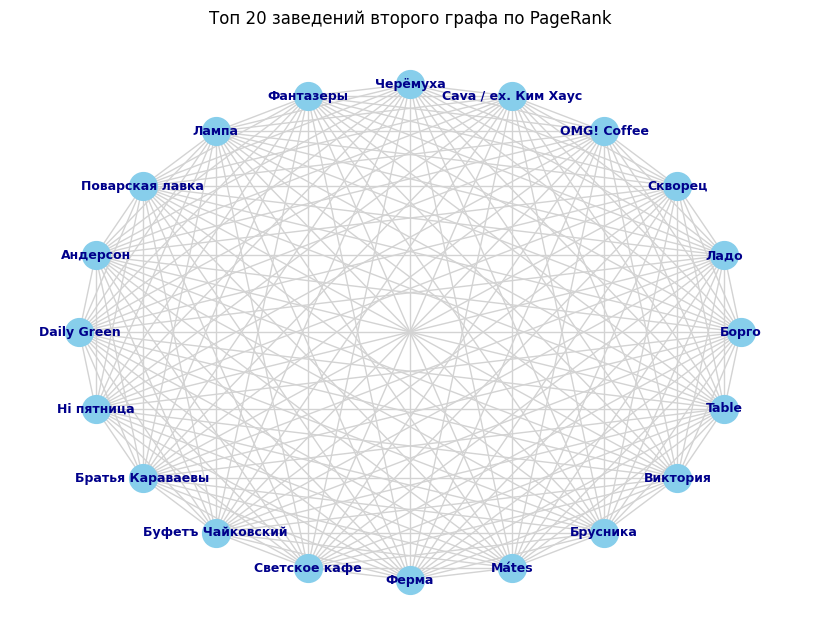

In [26]:
node_ids = df_pagerank_2.index.tolist()

subgraph = place2.subgraph(node_ids)

edge_color = 'lightgrey'
font_color = 'darkblue'
pos = nx.circular_layout(subgraph)

plt.figure(figsize=(8, 6))
nx.draw(subgraph,
        pos=pos,
        with_labels=True,
        labels=nx.get_node_attributes(subgraph, 'name'),
        node_size=400,
        node_color='skyblue',
        font_size=9,
        font_weight='bold',
        edge_color=edge_color,
        font_color=font_color)
plt.title("Топ 20 заведений второго графа по PageRank")
plt.show()

### Обнаружение сообществ в графе
Целью будет выявление схожих заведений по переданным признакам. Будем ожидать что наши заведения разобьются по типу кухни или среднему чеку.
Оценивать качество разбиения будем с помощью метрики модулярности, а также будем смотреть признаки в датасете после разбивки.

Определяем функцию которая будет выводить тип кухни и количество в каждом сообществе, она нужна чтобы оценивать что характеризует наше сообщетсво с точки зрения типа кухни

In [27]:
def cuisine_community_dataframe(df, community_dict):
    cuisine_count = {}

    for community in community_dict:
        for idx in community:
            cuisines = eval(df.iloc[idx]['cuisines'])
            for cuisine in cuisines:
                if cuisine not in cuisine_count:
                    cuisine_count[cuisine] = [0] * len(community_dict)
                cuisine_count[cuisine][list(community_dict).index(community)] += 1

    df_cuisine = pd.DataFrame(cuisine_count, index=[f'Community {i+1}' for i in range(len(community_dict))])
    df_cuisine.index.name = 'Community'
    return df_cuisine.transpose()

#### greedy_modularity_communities

In [28]:
from networkx.algorithms.community import greedy_modularity_communities
gmc_1 = greedy_modularity_communities(place1)
gmc_2 = greedy_modularity_communities(place2)

In [29]:
print(f'Количество сообществ в первом графе на основе алгоритма {len(gmc_1)}')
print(f'Модулярность = {nx.community.quality.modularity(place1, gmc_1)}')

Количество сообществ в первом графе на основе алгоритма 4
Модулярность = 0.07405070453453254


In [30]:
print(f'Количество сообществ во втором графе на основе алгоритма {len(gmc_2)}')
print(f'Модулярность = {nx.community.quality.modularity(place2, gmc_2)}')

Количество сообществ во втором графе на основе алгоритма 4
Модулярность = 0.08961728783030863


#### K-Means
Воспользуемся алгоритмом кластеризации k-means и будем подбирать оптимальное число кластеров на основе метрики модулярности наших сообществ

In [31]:
from sklearn.cluster import KMeans

In [32]:
modularity_scores_1 = []

for i in tqdm(range(1, 15)):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(nx.to_numpy_array(place1))
    labels = kmeans.labels_
    cluster_sets = [set() for _ in range(max(labels) + 1)]

    for node, cluster_label in enumerate(labels):
        cluster_sets[cluster_label].add(node)

    modularity_scores_1.append(nx.community.quality.modularity(place1, cluster_sets))

  0%|          | 0/14 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

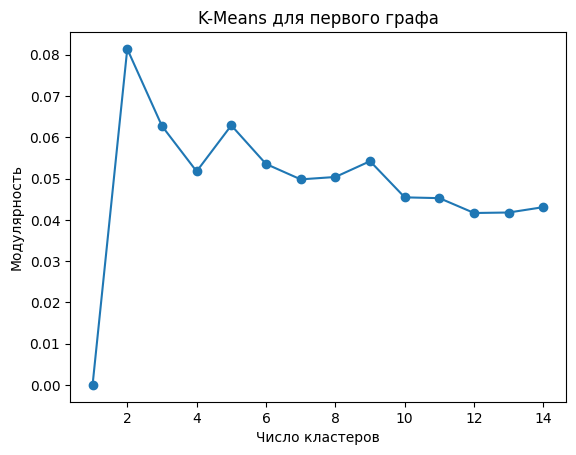

In [33]:
plt.plot(range(1, len(modularity_scores_1) + 1), modularity_scores_1, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Модулярность')
plt.title('K-Means для первого графа')
plt.show()

In [34]:
modularity_scores_2 = []

for i in tqdm(range(1, 15)):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(nx.to_numpy_array(place2))
    labels = kmeans.labels_
    cluster_sets = [set() for _ in range(max(labels) + 1)]

    for node, cluster_label in enumerate(labels):
        cluster_sets[cluster_label].add(node)

    modularity_scores_2.append(nx.community.quality.modularity(place2, cluster_sets))

  0%|          | 0/14 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

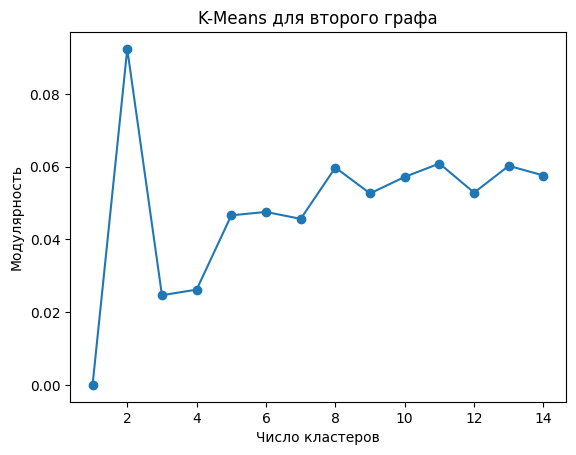

In [35]:
plt.plot(range(1, len(modularity_scores_2) + 1), modularity_scores_2, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Модулярность')
plt.title('K-Means для второго графа')
plt.show()

**Как мы видим из графика оптимальное число кластеров с модулярностью выше чем у остальных = 3** \
Применим алгоритм k-means с числом кластеров = 3 и посмотрим результаты на датасете

In [36]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(nx.to_numpy_array(place1))
labels = kmeans.labels_
cluster_sets = [set() for _ in range(max(labels) + 1)]

for node, cluster_label in enumerate(labels):
    cluster_sets[cluster_label].add(node)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Label-propogation

In [37]:
lpc_1 = list(nx.community.label_propagation_communities(place1))
lpc_2 = list(nx.community.label_propagation_communities(place2))

In [38]:
print(f'Количество сообществ lpa в первом графе {len(lpc_1)}')
print(f'Модулярность = {nx.community.quality.modularity(place1, lpc_1)}')

Количество сообществ lpa в первом графе 3
Модулярность = 0.012336787869984525


In [39]:
print(f'Количество сообществ lpa во втором графе {len(lpc_2)}')
print(f'Модулярность = {nx.community.quality.modularity(place2, lpc_2)}')

Количество сообществ lpa во втором графе 3
Модулярность = 0.014369991765167017


#### Лувенский алгоритм

In [40]:
louvс_1 = list(nx.community.louvain_communities(place1, weight='weight'))
louvс_2 = list(nx.community.louvain_communities(place2, weight='weight'))

In [41]:
print(f'Количество сообществ в первом графе (Лувенский алгоритм): {len(louvс_1)}')
print(f'Модулярность = {nx.community.quality.modularity(place1, louvс_1)}')

Количество сообществ в первом графе (Лувенский алгоритм): 6
Модулярность = 0.10441762935189446


In [42]:
print(f'Количество сообществ во втором графе (Лувенский алгоритм): {len(louvс_2)}')
print(f'Модулярность = {nx.community.quality.modularity(place2, louvс_2)}')

Количество сообществ во втором графе (Лувенский алгоритм): 7
Модулярность = 0.1362969644982304


In [43]:
df1 = cuisine_community_dataframe(places, louvс_1)
percentage_df = df1.copy()
for col in percentage_df.columns[0:]:
    total = percentage_df[col].sum()
    percentage_df[col] = (percentage_df[col] / total) * 100

In [50]:
percentage_df

Community,Community 1,Community 2,Community 3,Community 4,Community 5,Community 6
пончики,100.0,0.000000,0.000000,0.089726,0.000000,0.000000
японская,0.0,6.760563,0.342075,0.179453,0.000000,0.000000
азиатская,0.0,12.535211,0.114025,0.000000,0.000000,0.000000
американская,0.0,3.239437,0.456100,2.063706,0.888889,0.232829
бургеры,0.0,1.901408,0.228050,1.166442,0.444444,0.000000
турецкая,0.0,1.690141,0.000000,0.314042,0.000000,0.000000
восточная,0.0,5.845070,0.000000,0.852400,0.444444,1.280559
стейки,0.0,2.183099,0.570125,2.602064,0.888889,0.232829
вегетарианская,0.0,2.183099,0.228050,0.493495,0.000000,0.000000
рыба и морепродукты,0.0,4.436620,0.570125,1.884253,2.222222,0.116414


In [44]:
df2 = cuisine_community_dataframe(places, louvс_2)
percentage_df2 = df2.copy()
for col in percentage_df2.columns[0:]:
    total = percentage_df2[col].sum()
    percentage_df2[col] = (percentage_df2[col] / total) * 100

In [51]:
percentage_df2

Community,Community 1,Community 2,Community 3,Community 4,Community 5,Community 6,Community 7
итальянская,41.715629,0.000000,0.000000,0.0,0.000000,0.000000,1.036269
европейская,28.202115,15.483871,29.676259,0.0,1.688183,50.922910,32.987910
средиземноморская,1.410106,0.000000,2.158273,0.0,4.766634,2.008686,0.000000
греческая,0.117509,0.000000,0.000000,0.0,1.290963,0.162866,0.000000
французская,0.470035,0.000000,0.000000,0.0,0.993049,0.868621,0.345423
пицца,17.508813,0.000000,0.899281,0.0,0.297915,3.203040,0.518135
суши,1.175088,0.129032,2.158273,0.0,5.461768,2.117264,0.172712
десерты,0.822562,0.129032,0.899281,0.0,0.496524,3.257329,0.172712
вино,1.880141,0.516129,0.719424,0.0,1.290963,2.823018,0.863558
рыба и морепродукты,0.587544,0.129032,0.719424,0.0,5.163853,2.660152,0.863558


### Интерпретация результатов

In [45]:
community_average_check = {}
k = 1
for community in louvс_1:
    community_df = places[places.index.isin(community)]
    average_check = community_df['average_check'].mean()
    community_average_check[k] = average_check
    k+=1
result_df1 = pd.DataFrame(list(community_average_check.items()), columns=['Сообщество', 'Средний чек'])

In [46]:
community_average_check = {}
k = 1
for community in louvс_2:
    community_df = places[places.index.isin(community)]
    average_check = community_df['average_check'].mean()
    community_average_check[k] = average_check
    k+=1
result_df2 = pd.DataFrame(list(community_average_check.items()), columns=['Сообщество', 'Средний чек'])

In [47]:
result_df1

,Сообщество,Средний чек
0,1,450.000000
1,2,1669.972100
2,3,1836.548913
3,4,1616.829694
4,5,1593.394495
5,6,1400.126263


In [48]:
result_df2

,Сообщество,Средний чек
0,1,1853.380282
1,2,1395.179063
2,3,1650.604839
3,4,450.000000
4,5,1684.569138
5,6,1596.657350
6,7,1626.044776


### Посмотрим как Лувенский алгоритм разбил наш граф на сообщества и посмотрим топ 5 кухонь в этих сообществах

#### Можем сделать вывод о качественной разбивке нашего графа. Алгоритм хорошо распознал классы ресторанов которые имеют сходство по типу кухни, можем интерпретировать результаты:
1 Сообщество: заведения, которые специализируются русской и европейской кухне \
2 Сообщество: заведения азиатской кухни в том числе, специализирующиеся на морепродуктах и суши. \
3 Сообщество: заведения итальянской, средиземноморской кухни, в том числе специализирующие на пицце и вине. \
4 Сообщество: заведения кавказской и грузинской кухонь, а также заведения, в которых подают хинкали и шашлыки, что тоже говорит о принадлежности к кавказской народности. \
5 Сообщество: заведения смешанной кухни с доминирующим числом заведений европейской кухни. \
6 Сообщество: заведения европейской кухни, в которых специализируются на стейках десертах и прочем. \
7 Сообщество: заведения, которые полностью специализируются на пончиках (возможно сетевой стритфуд).

### Визуализируем граф, где каждое сообщетсво будет иметь свой цвет, а узлы будут иметь размер в зависимости от меры центральности

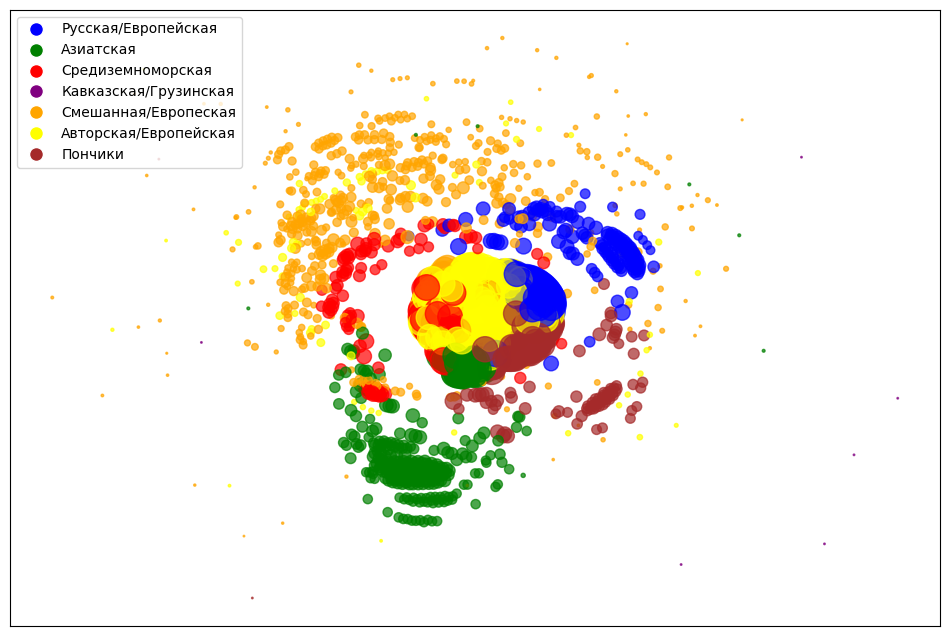

In [49]:
class_colors = {
    1: 'blue',
    2: 'green',
    3: 'red',
    4: 'purple',
    5: 'orange',
    6: 'yellow',
    7: 'brown'
}

legend_labels = ['Русская/Европейская', 'Азиатская', 'Средиземноморская', 'Кавказская/Грузинская', 'Смешанная/Европеская', 'Авторская/Европейская', 'Пончики']
legend_handles = []

community_colors = {}

for i, community in enumerate(louvс_2):
    for node in community:
        community_colors[node] = class_colors[i+1]

for i, label in enumerate(legend_labels):
    color = class_colors[i + 1]
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label))

node_colors = [community_colors[node] for node in place2.nodes()]
node_sizes = [degree_centrality_2[node] * 500 for node in place2.nodes()]


plt.figure(figsize=(12, 8))
pos = nx.spring_layout(place2, k=0.4)

nx.draw_networkx_nodes(place2, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)


plt.legend(handles=legend_handles, loc='upper left')

plt.show()